# Panel A

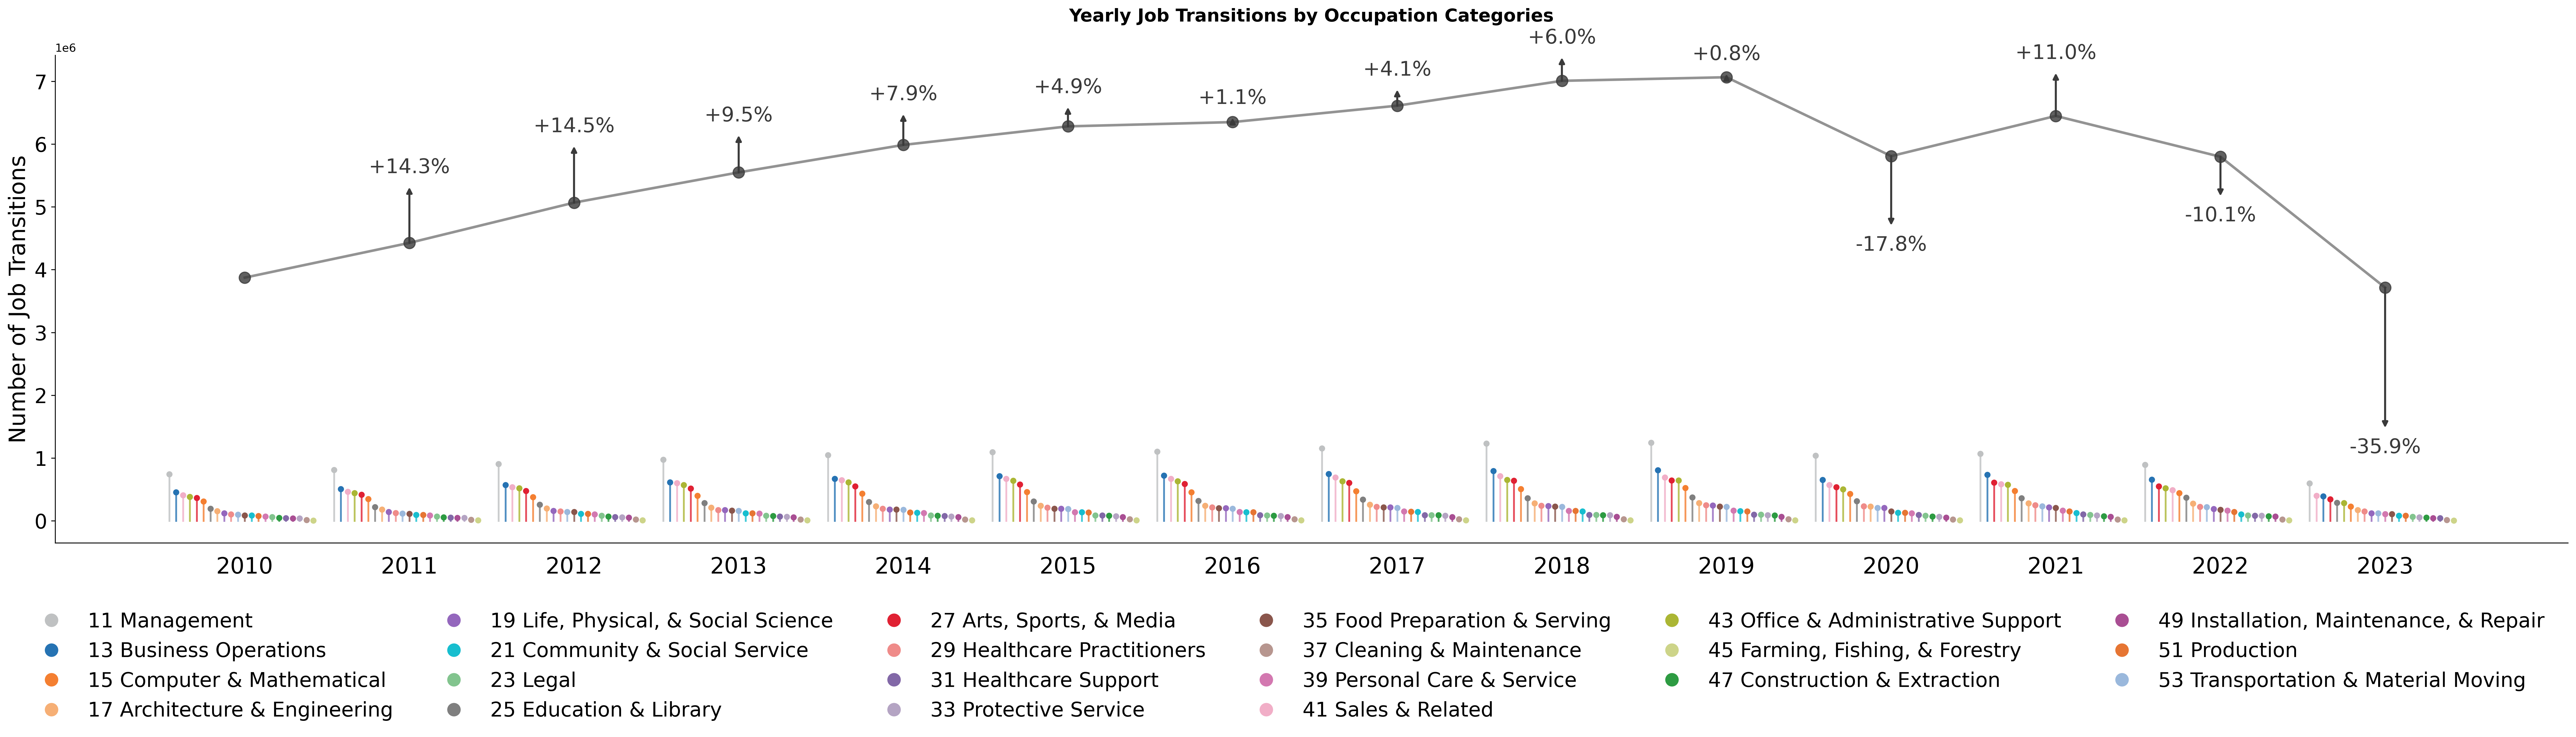

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormapß

df = pd.read_parquet("/bgfs/mrfrank/wendi/revelio_v2_new/Modelling_Data/cleaned/datasetB.parquet")

occupation_style_map = {
    "11": {"name": "Management", "color": "#BFC1C2"},
    "13": {"name": "Business Operations", "color": "#2673B3"},
    "15": {"name": "Computer & Mathematical", "color": "#F47F31"},
    "17": {"name": "Architecture & Engineering", "color": "#F6AF75"},
    "19": {"name": "Life, Physical, & Social Science", "color": "#9467bd"},
    "21": {"name": "Community & Social Service", "color": "#17becf"},
    "23": {"name": "Legal", "color": "#82C48E"},
    "25": {"name": "Education & Library", "color": "#7f7f7f"},
    "27": {"name": "Arts, Sports, & Media", "color": "#E02133"},
    "29": {"name": "Healthcare Practitioners", "color": "#EF8B89"},
    "31": {"name": "Healthcare Support", "color": "#8268A7"},
    "33": {"name": "Protective Service", "color": "#B4A4C3"},
    "35": {"name": "Food Preparation & Serving", "color": "#8A564C"},
    "37": {"name": "Cleaning & Maintenance", "color": "#B7968F"},
    "39": {"name": "Personal Care & Service", "color": "#D378B0"},
    "41": {"name": "Sales & Related", "color": "#F1AEC7"},
    "43": {"name": "Office & Administrative Support", "color": "#ABB634"},
    "45": {"name": "Farming, Fishing, & Forestry", "color": "#CDD489"},
    "47": {"name": "Construction & Extraction", "color": "#2D9B42"},
    "49": {"name": "Installation, Maintenance, & Repair", "color": "#A94E93"},
    "51": {"name": "Production", "color": "#E67533"},
    "53": {"name": "Transportation & Material Moving", "color": "#9AB8DC"}
}
OTHER_COLOR = "#B0B0B0"

df = df.copy()
df["year_j"] = pd.to_numeric(df["year_j"], errors="coerce")
df = df.dropna(subset=["year_j"])
df["year_j"] = df["year_j"].astype(int)
df["soc2"] = df["onet_code_j"].str.slice(0, 2)

g = df.groupby(["year_j", "soc2"], observed=True)["count"].sum().reset_index()

tot = g.groupby("year_j", as_index=False)["count"].sum().sort_values("year_j")

fig, ax = plt.subplots(figsize=(32, 8), dpi=300)
ax.set_axis_off()

years = np.sort(g["year_j"].unique())

for y in years:
    gi = g[g["year_j"] == y].copy().sort_values("count", ascending=False)
    xi_positions = np.arange(len(gi))
    x = xi_positions + (y - years.min()) * (len(gi) + 2)
    yvals = gi["count"].values

    for i, (soc, val) in enumerate(zip(gi["soc2"], yvals)):
        c = occupation_style_map.get(soc, {"color": OTHER_COLOR})["color"]
        ax.plot([x[i], x[i]], [0, val], color=c, alpha=0.8, lw=1.6)
        ax.scatter(x[i], val, color=c, s=20)
ax.set_xticks([])     
ax.set_xticklabels([]) 

ax.plot(
    (years - years.min()) * (len(gi) + 2) + len(gi) / 2,
    tot["count"],
    color="#3A3A3A", lw=2.3, alpha=0.55
)
ax.scatter(
    (years - years.min()) * (len(gi) + 2) + len(gi) / 2,
    tot["count"],
    color="#3A3A3A", s=100
    , alpha=0.8
)

nmax = g.groupby('year_j')['soc2'].nunique().max()
spacing = nmax + 2
centers = (years - years.min()) * spacing + nmax / 2

tot_sorted = tot.set_index('year_j').loc[years, 'count'].astype(float).values
pct_change = pd.Series(tot_sorted, index=years).pct_change()

ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
scale = 0.8 * yrange   

for i in range(1, len(years)):
    change = pct_change.iloc[i]
    if pd.isna(change):
        continue
    dy = np.sign(change) * abs(change) * scale
    x0, y0 = centers[i], tot_sorted[i]

    ax.annotate(
        '', xy=(x0, y0 + dy), xytext=(x0, y0),
        arrowprops=dict(arrowstyle='-|>', lw=1.8, color="#3A3A3A",
                        shrinkA=0, shrinkB=0)
    )
    ax.text(
        x0, y0 + dy + (0.02 * yrange if change >= 0 else -0.02 * yrange),
        f'{change:+.1%}', ha='center',
        va='bottom' if change >= 0 else 'top',
        fontsize=18, color="#3A3A3A"
    )


for i, y in enumerate(years):
    x_center = (y - years.min()) * (len(gi) + 2) + len(gi) / 2
    ax.text(x_center, -0.08* tot["count"].max(), str(y),
            ha="center", va="top", fontsize=20)

ax.set_axis_on()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Number of Job Transitions", fontsize=20)
ax.tick_params(axis='y', labelsize=18)
ax.set_title("Yearly Job Transitions by Occupation Categories", fontsize=16, weight="bold", pad=30)

legend_items = []
for soc_code, meta in occupation_style_map.items():
    legend_items.append(
        Line2D([0], [0], marker='o',markersize=12, markeredgewidth=0, markerfacecolor=meta["color"], color='none',lw=3, label=f'{soc_code} {meta["name"]}')
    )
leg = fig.legend(
    handles=legend_items, loc="lower center",
    ncol=6, frameon=False, fontsize=18,
    #title="Destination SOC (2-digit)", title_fontsize=10,
    bbox_to_anchor=(0.5, -0.15)
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
save_path = "FINAL/fig1.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

# Panel B

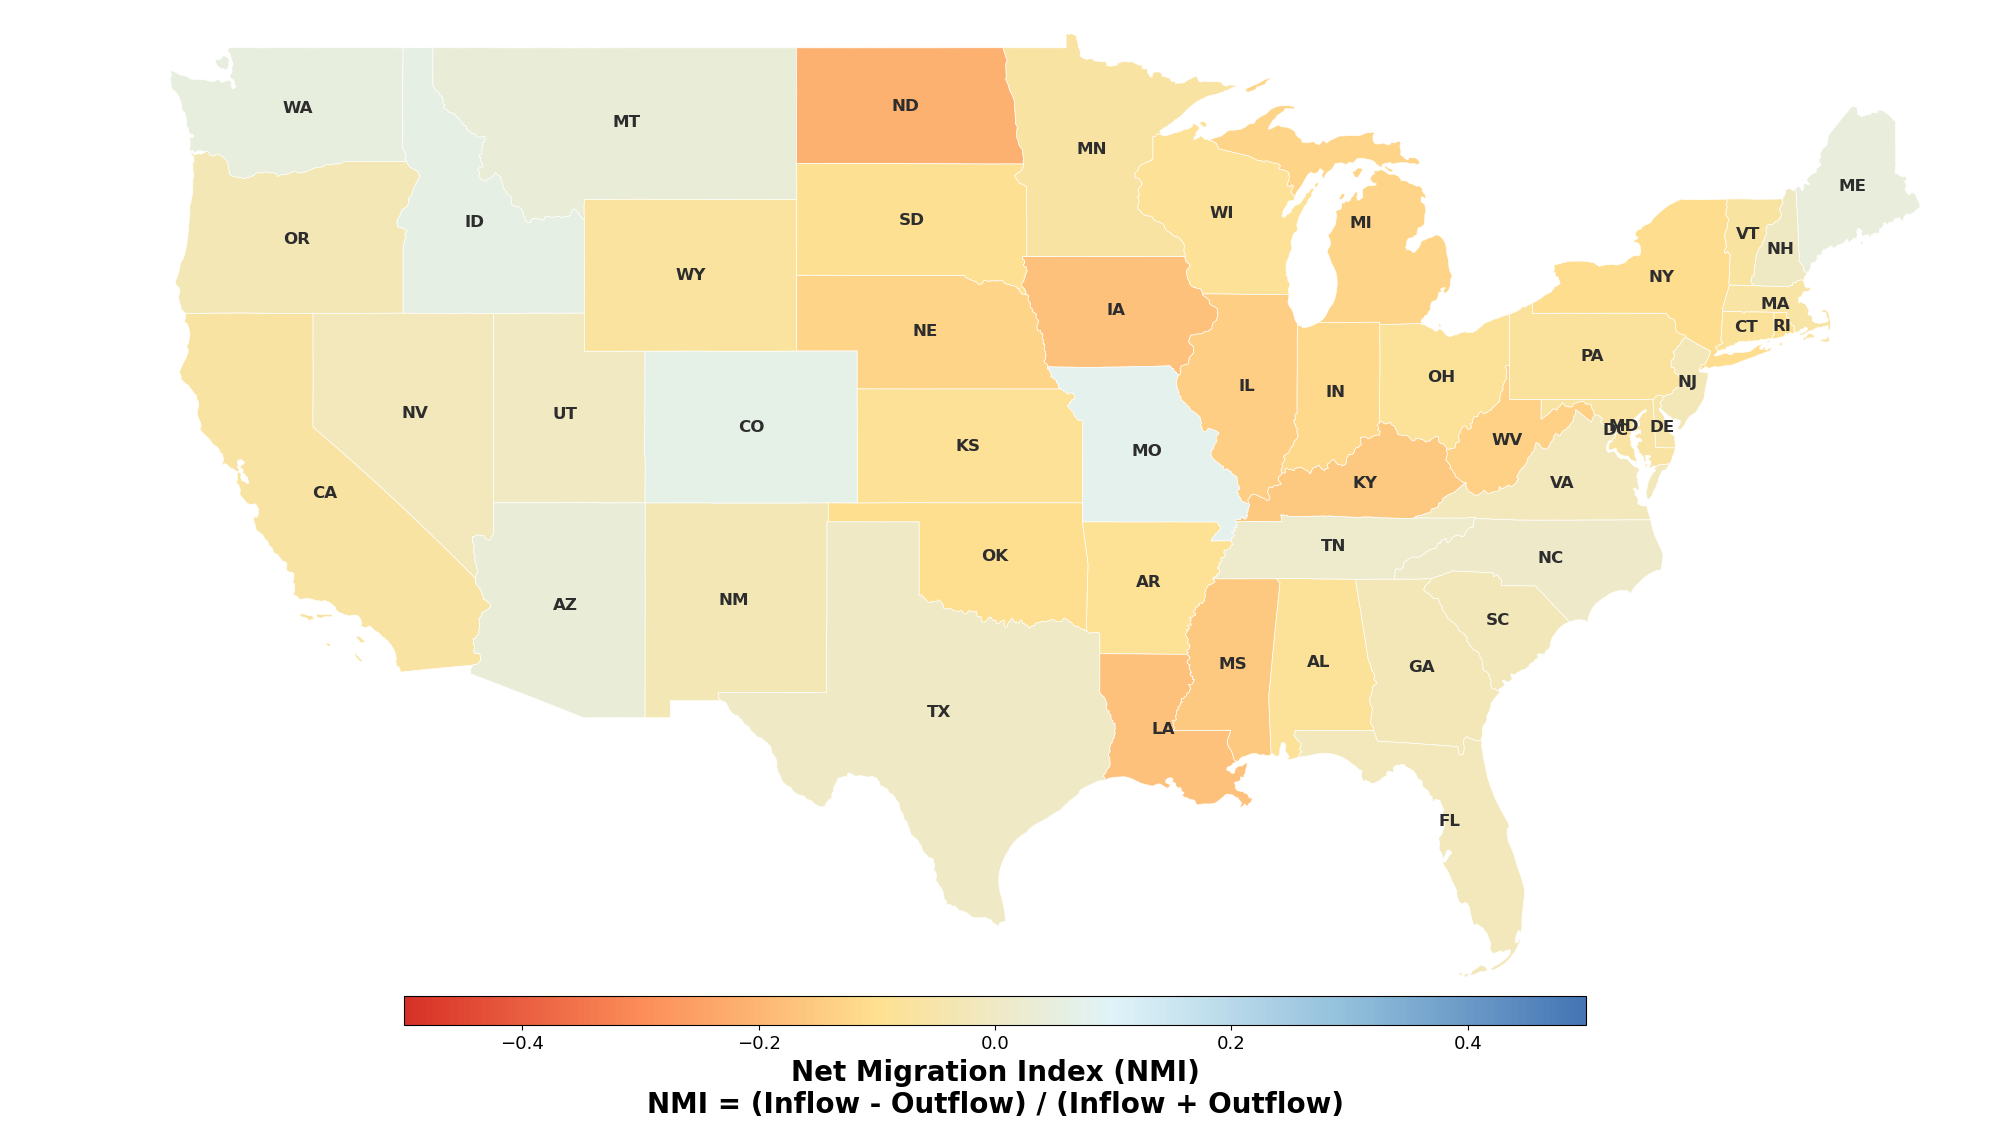

In [26]:
df = pd.read_parquet("/bgfs/mrfrank/wendi/Job-Transition_Project/DATA/job_transition/year_edu_6types_counts_ST_SE.parquet")

df_2020 = df[df['year_j'] == 2020].copy()
outflow = df_2020[df_2020['state_i'] != df_2020['state_j']].groupby('state_i')['count'].sum()
inflow = df_2020[df_2020['state_i'] != df_2020['state_j']].groupby('state_j')['count'].sum()
all_states = pd.Index(df['state_i'].unique()).difference(['empty'])
outflow = outflow.reindex(all_states, fill_value=0)
inflow = inflow.reindex(all_states, fill_value=0)
nmi = (inflow - outflow) / (inflow + outflow)
nmi = nmi.replace([np.inf, -np.inf], np.nan)
state_name_map = {
    'Washington, D.C.': 'District of Columbia'
}
nmi.index = nmi.index.map(lambda x: state_name_map.get(x, x))
usa = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip')
usa = usa[~usa['STUSPS'].isin(['AK', 'HI', 'PR', 'VI', 'GU', 'MP', 'AS'])]
nmi_df = pd.DataFrame({'NAME': nmi.index, 'NMI': nmi.values})
usa = usa.merge(nmi_df, on='NAME', how='left')
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
cmap = LinearSegmentedColormap.from_list('nmi', colors, N=256)
vmin, vmax = -0.5, 0.5
usa.plot(column='NMI', ax=ax, cmap=cmap, edgecolor='white', linewidth=0.5, 
         legend=False, vmin=vmin, vmax=vmax, missing_kwds={'color': '#e0e0e0'})
for idx, row in usa.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['STUSPS'], 
            ha='center', va='center', fontsize=12, fontweight='bold', color='#2d2d2d')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.0, 
                    aspect=40, shrink=0.6)
cbar.set_label('Net Migration Index (NMI)\nNMI = (Inflow - Outflow) / (Inflow + Outflow)', 
               fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=13)
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.axis('off')
plt.tight_layout()
plt.savefig('FINAL/state_nmi_map_2020.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Panel C

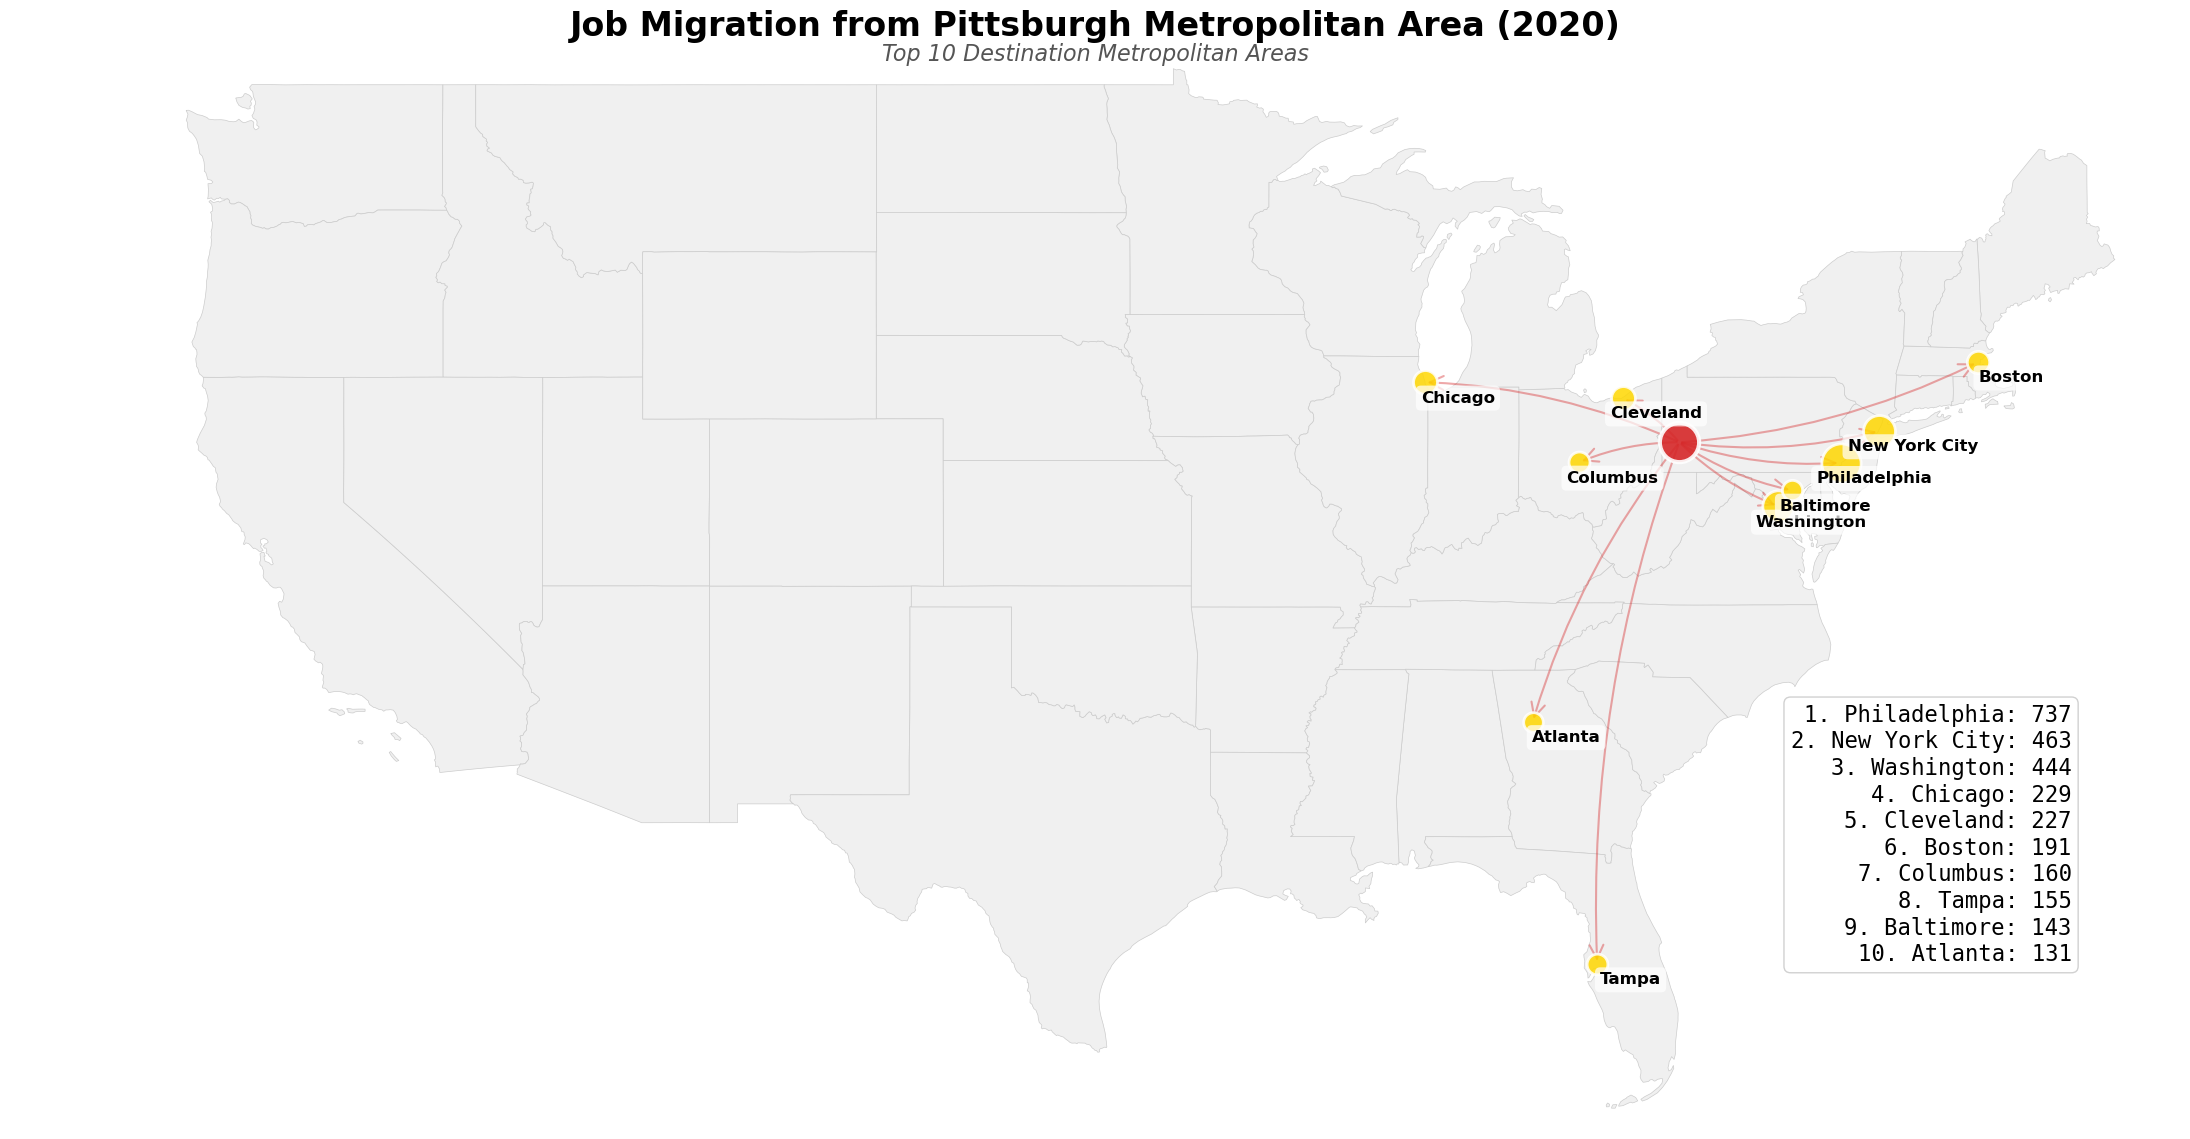

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

metro_coords = {
    'pittsburgh metropolitan area': (-79.9959, 40.4406),
    'new york city metropolitan area': (-74.0060, 40.7128),
    'philadelphia metropolitan area': (-75.1652, 39.9526),
    'washington metropolitan area': (-77.0369, 38.9072),
    'chicago metropolitan area': (-87.6298, 41.8781),
    'los angeles metropolitan area': (-118.2437, 34.0522),
    'boston metropolitan area': (-71.0589, 42.3601),
    'dallas metropolitan area': (-96.7970, 32.7767),
    'houston metropolitan area': (-95.3698, 29.7604),
    'atlanta metropolitan area': (-84.3880, 33.7490),
    'miami metropolitan area': (-80.1918, 25.7617),
    'seattle metropolitan area': (-122.3321, 47.6062),
    'phoenix metropolitan area': (-112.0740, 33.4484),
    'san francisco metropolitan area': (-122.4194, 37.7749),
    'detroit metropolitan area': (-83.0458, 42.3314),
    'minneapolis metropolitan area': (-93.2650, 44.9778),
    'tampa metropolitan area': (-82.4572, 27.9506),
    'denver metropolitan area': (-104.9903, 39.7392),
    'st louis metropolitan area': (-90.1994, 38.6270),
    'baltimore metropolitan area': (-76.6122, 39.2904),
    'charlotte metropolitan area': (-80.8431, 35.2271),
    'orlando metropolitan area': (-81.3792, 28.5383),
    'san antonio metropolitan area': (-98.4936, 29.4241),
    'portland metropolitan area': (-122.6765, 45.5152),
    'sacramento metropolitan area': (-121.4944, 38.5816),
    'san diego metropolitan area': (-117.1611, 32.7157),
    'las vegas metropolitan area': (-115.1398, 36.1699),
    'cleveland metropolitan area': (-81.6944, 41.4993),
    'columbus metropolitan area': (-82.9988, 39.9612),
    'cincinnati metropolitan area': (-84.5120, 39.1031),
    'kansas city metropolitan area': (-94.5786, 39.0997),
    'indianapolis metropolitan area': (-86.1581, 39.7684),
    'austin metropolitan area': (-97.7431, 30.2672),
    'nashville metropolitan area': (-86.7816, 36.1627),
    'virginia beach metropolitan area': (-76.0892, 36.8529),
    'raleigh metropolitan area': (-78.6382, 35.7796)
}

df_pittsburgh = df[(df['metro_area_i'] == 'pittsburgh metropolitan area') & 
                   (df['year_j'] == 2020) & 
                   (df['metro_area_i'] != df['metro_area_j']) &
                   (df['metro_area_j'] != 'empty') &
                   (~df['metro_area_j'].str.contains('nonmetropolitan', case=False, na=False))].copy()

top10_destinations = df_pittsburgh.groupby('metro_area_j')['count'].sum().sort_values(ascending=False).head(10)

usa = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip')
usa = usa[~usa['STUSPS'].isin(['AK', 'HI', 'PR', 'VI', 'GU', 'MP', 'AS'])]

fig, ax = plt.subplots(1, 1, figsize=(22, 14))

usa.plot(ax=ax, color='#f0f0f0', edgecolor='#cccccc', linewidth=0.5)

origin = metro_coords['pittsburgh metropolitan area']
ax.scatter(origin[0], origin[1], s=800, c='#d62728', marker='o', 
          edgecolor='white', linewidth=3, zorder=100, alpha=0.9, label='Pittsburgh (Origin)')

max_count = top10_destinations.max()
min_count = top10_destinations.min()

for metro, count in top10_destinations.items():
    if metro in metro_coords:
        dest = metro_coords[metro]
        
        size = 200 + (count - min_count) / (max_count - min_count) * 600
        ax.scatter(dest[0], dest[1], s=size, c='#ffd700', marker='o', 
                  edgecolor='white', linewidth=2, zorder=50, alpha=0.85)
        
        arrow = FancyArrowPatch(origin, dest, 
                              arrowstyle='->', mutation_scale=25, 
                              linewidth=1.5, color='#d62728', alpha=0.4,
                              connectionstyle="arc3,rad=0.1", zorder=10)
        ax.add_patch(arrow)
        
        metro_name = metro.replace(' metropolitan area', '').title()
        ax.text(dest[0]+1, dest[1] - 0.2, metro_name, 
               ha='center', va='top', fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                        edgecolor='none', alpha=0.7), zorder=100)

ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.axis('off')

ax.text(0.5, 1.00, 'Job Migration from Pittsburgh Metropolitan Area (2020)',
        transform=ax.transAxes, fontsize=24, fontweight='bold', 
        ha='center', va='bottom')
ax.text(0.5, 1, 'Top 10 Destination Metropolitan Areas',
        transform=ax.transAxes, fontsize=16, ha='center', va='top', 
        style='italic', color='#555555')

textstr = '\n'.join([f"{i+1}. {metro.replace(' metropolitan area', '').title()}: {count:,}" 
                     for i, (metro, count) in enumerate(top10_destinations.items())])
props = dict(boxstyle='round', facecolor='white', edgecolor='#cccccc', alpha=0.9)
# ax.text(0.02, 0.35, textstr, transform=ax.transAxes, fontsize=11,
#         verticalalignment='top', bbox=props, family='monospace')

ax.text(0.95, 0.15, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='bottom', horizontalalignment='right', bbox=props, family='monospace')
plt.tight_layout()
plt.savefig('FINAL/pittsburgh_migration_map_2020.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()